In [1]:
from mimic.utilities.utilities import set_all_seeds
from mimic.utilities.utilities import plot_gLV
from mimic.model_infer import *
from mimic.model_simulate import *
import pandas as pd


import numpy as np


import matplotlib.pyplot as plt


from scipy.integrate import odeint


from numpy import linalg as la

import sklearn.linear_model


from sklearn.linear_model import LinearRegression


from sklearn.linear_model import Ridge


from sklearn.linear_model import Lasso


from sklearn.linear_model import ElasticNet, ElasticNetCV


from sklearn.model_selection import RepeatedKFold


from sklearn.model_selection import cross_val_score


from sklearn.model_selection import KFold


from sklearn.model_selection import GridSearchCV


import sys


sys.path.append("../../")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Simulate some time course data from the gLV


### Five species, single time course

Model parameters:
Model: gLV
num_species: 5
mu: [1.28 0.56 2.07 0.86 0.7 ]
M: [[-0.05  0.   -0.03  0.    0.  ]
 [ 0.   -0.1   0.    0.05  0.  ]
 [ 0.    0.   -0.15  0.    0.  ]
 [ 0.    0.    0.   -0.01  0.  ]
 [ 0.02  0.    0.    0.   -0.2 ]]
Using the following parameters for gLV simulation: {'num_species': 5, 'mu': array([1.27853844, 0.55683415, 2.06752757, 0.86387608, 0.70448068]), 'M': array([[-0.05 ,  0.   , -0.025,  0.   ,  0.   ],
       [ 0.   , -0.1  ,  0.   ,  0.05 ,  0.   ],
       [ 0.   ,  0.   , -0.15 ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , -0.01 ,  0.   ],
       [ 0.02 ,  0.   ,  0.   ,  0.   , -0.2  ]])}


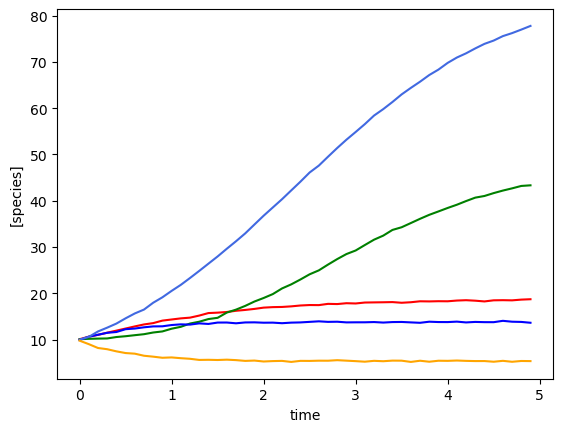

In [2]:
# In this example n >> p and it it is basically same as standard regression
# We have to be careful as most of these gLV models are very weakly identifiable

set_all_seeds(1234)

# SETUP MODEL
# establish size of model
num_species = 5

# construct interaction matrix
# TODO do this programmatically
M = np.zeros((num_species, num_species))
np.fill_diagonal(M, [-0.05, -0.1, -0.15, -0.01, -0.2])
M[0, 2] = -0.025
M[1, 3] = 0.05
M[4, 0] = 0.02

# construct growth rates matrix
mu = np.random.lognormal(0.01, 0.5, num_species)

# instantiate simulator
simulator = sim_gLV(num_species=num_species,
                    M=M,
                    mu=mu)
simulator.print_parameters()

# PRODUCE SIMULATED RESULTS
# initial conditions
init_species = 10 * np.ones(num_species)

times = np.arange(0, 5, 0.1)
yobs, init_species, mu, M = simulator.simulate(
    times=times, init_species=init_species)

# add some gaussian noise
yobs = yobs + np.random.normal(loc=0, scale=0.1, size=yobs.shape)


# plot simulation
plot_gLV(yobs, times)